In [1]:
import pandas as pd
import os
from src.data import files_to_df

SOURCE_PATH_ORIG = "data/1_original/txt"
SOURCE_PATH_GEN = "data/2_generated/2step_transformation_dt4h_GPT4omini/en"

def create_pairs(path_orig, path_gen):

    df_gen = files_to_df(path_gen)
    df_gen["filenameid"] = df_gen["filenameid"].str.replace("_transformed_step1", "")

    df_orig = files_to_df(path_orig)
    df_pairs = df_orig.merge(df_gen, on="filenameid", suffixes=("_orig", "_gen"))
    # assert len(df_pairs) == N_EXPECTED_SAMPLES, f"Expected {N_EXPECTED_SAMPLES} samples, got {len(df_pairs)}"

    df_pairs.rename(columns={"text_orig": "clinical_case", "text_gen": "discharge_summary"}, inplace=True)
    return df_pairs

df_pairs = create_pairs(SOURCE_PATH_ORIG, SOURCE_PATH_GEN)

df_cc_ents = pd.read_csv("nbs/evaluation/automatic/cardioner_entities/NOIOB_EN_clinical_case_ents.tsv", sep="\t")
df_cc_ents["codes"] = df_cc_ents["codes"].apply(eval)
df_cc_ents["terms"] = df_cc_ents["terms"].apply(eval)
df_cc_ents["mention_id"] = df_cc_ents.index

df_ds_ents = pd.read_csv("nbs/evaluation/automatic/cardioner_entities/NOIOB_EN_discharge_summary_ents.tsv", sep="\t")
df_ds_ents["codes"] = df_ds_ents["codes"].apply(eval)
df_ds_ents["terms"] = df_ds_ents["terms"].apply(eval)
df_ds_ents["mention_id"] = df_ds_ents.index

In [2]:
print(df_cc_ents.duplicated(subset=["filenameid", "text"]).sum())
print(df_ds_ents.duplicated(subset=["filenameid", "text"]).sum())

df_cc_ents = df_cc_ents.drop_duplicates(subset=["filenameid", "text"])
df_ds_ents = df_ds_ents.drop_duplicates(subset=["filenameid", "text"])

print(df_cc_ents.duplicated(subset=["filenameid", "text"]).sum())
print(df_ds_ents.duplicated(subset=["filenameid", "text"]).sum())

39
25
0
0


In [3]:
ex1 = df_cc_ents.loc[df_cc_ents["filenameid"] == "33175723_1", ["filenameid", "label", "text", "terms", "mention_id"]]
ex2 = df_ds_ents.loc[df_ds_ents["filenameid"] == "33175723_1", ["filenameid", "label", "text", "terms", "mention_id"]]

In [4]:
ex1.shape, ex2.shape

((34, 5), (35, 5))

In [5]:
df_ex = ex1.merge(ex2, on=["filenameid"], how="outer", suffixes=("_cc", "_ds"))#[["filenameid", "codes_cc", "codes_ds"]].to_dict(orient="records")

In [6]:
df_ex["inter_size"] = df_ex.apply(lambda x: len(set(x["terms_cc"]).intersection(set(x["terms_ds"]))), axis=1)
df_ex["positive"] = df_ex.apply(lambda x: 1 if x["inter_size"] > 0 else 0, axis=1)

In [7]:
df_ex.sort_values(by=["inter_size"], ascending=False)

,filenameid,label_cc,text_cc,terms_cc,mention_id_cc,label_ds,text_ds,terms_ds,mention_id_ds,inter_size,positive
144,33175723_1,DISEASE,primary AL amyloidosis,"[AL amyloidosis, Primary amyloidosis, Sporadic...",4,DISEASE,Primary AL amyloidosis,"[AL amyloidosis, Primary amyloidosis, Sporadic...",4,10,1
1189,33175723_1,SYMPTOM,sinus rhythm,"[Sinus rhythm, SR - Sinus rhythm, Coronary sin...",23573,SYMPTOM,sinus rhythm,"[Sinus rhythm, SR - Sinus rhythm, Coronary sin...",23035,10,1
576,33175723_1,PROCEDURE,echocardiography,"[Echocardiography, Echocardiogram, Echocardiog...",12227,PROCEDURE,Echocardiography,"[Echocardiography, Echocardiogram, Echocardiog...",12237,10,1
36,33175723_1,DISEASE,cardiac amyloidosis,"[Cardiac amyloidosis, Senile cardiac amyloidos...",1,DISEASE,Cardiac amyloidosis,"[Cardiac amyloidosis, Senile cardiac amyloidos...",1,10,1
289,33175723_1,DISEASE,periorbital hematoma,"[Periorbital hematoma, Periorbital haematoma, ...",8,DISEASE,periorbital hematoma,"[Periorbital hematoma, Periorbital haematoma, ...",9,10,1
...,...,...,...,...,...,...,...,...,...,...,...
404,33175723_1,DISEASE,cardioembolic cerebral event,"[Cardioembolic stroke, Cardiac embolism, Cereb...",11,PROCEDURE,Echocardiographic evaluation,"[Echocardiography, Echocardiographic procedure...",12240,0,0
403,33175723_1,DISEASE,cardioembolic cerebral event,"[Cardioembolic stroke, Cardiac embolism, Cereb...",11,PROCEDURE,ECG,"[Electrocardiogram, Electrocardiography proced...",12239,0,0
402,33175723_1,DISEASE,cardioembolic cerebral event,"[Cardioembolic stroke, Cardiac embolism, Cereb...",11,PROCEDURE,electrocardiogram,"[Electrocardiogram, Electrocardiograph, Electr...",12238,0,0
401,33175723_1,DISEASE,cardioembolic cerebral event,"[Cardioembolic stroke, Cardiac embolism, Cereb...",11,PROCEDURE,Echocardiography,"[Echocardiography, Echocardiogram, Echocardiog...",12237,0,0


In [8]:
def get_notnull_intersection(group):
    return group[group["inter_size"] > 0].sort_values(by="inter_size", ascending=False)["text_ds"].tolist()

In [9]:
len(list(set(df_ex.groupby("text_cc").apply(get_notnull_intersection).sum())))

/scratch/tmp/ipykernel_2980093/4088920469.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  len(list(set(df_ex.groupby("text_cc").apply(get_notnull_intersection).sum())))


34

In [10]:
len(list(set(df_ex.groupby("text_ds").apply(get_notnull_intersection).sum())))

/scratch/tmp/ipykernel_2980093/642089737.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  len(list(set(df_ex.groupby("text_ds").apply(get_notnull_intersection).sum())))


34

In [11]:
df_total = df_cc_ents.merge(df_ds_ents, on=["filenameid"], how="outer", suffixes=("_cc", "_ds"))
df_total = df_total[df_total["label_cc"] == df_total["label_ds"]]

In [12]:
df_total["inter_size"] = df_total.apply(lambda x: len(set(x["terms_cc"]).intersection(set(x["terms_ds"]))), axis=1)

# df_total = df_total.sort_values(by=["filenameid", "mention_id_cc", "inter_size"], ascending=[True, True, False])

df_total[df_total["filenameid"] == "39101327"]

,label_cc,text_cc,filenameid,codes_cc,terms_cc,mention_id_cc,label_ds,text_ds,codes_ds,terms_ds,mention_id_ds,inter_size
1142677,DISEASE,Whipple disease,39101327,"[41545003, 41545003, 41545003, 41545003, 23019...","[Whipple disease, Whipple's disease, Intestina...",7871,DISEASE,severe malnutrition,"[29740003, 2492009, 58262005, 248325000, 44195...","[Severe malnutrition, Malnutrition, Malignant ...",7979,0
1142678,DISEASE,Whipple disease,39101327,"[41545003, 41545003, 41545003, 41545003, 23019...","[Whipple disease, Whipple's disease, Intestina...",7871,DISEASE,cardiogenic shock,"[89138009, 417343009, 328851000119107, 2794200...","[Cardiogenic shock, Vasogenic shock, Cardiogen...",7980,0
1142679,DISEASE,Whipple disease,39101327,"[41545003, 41545003, 41545003, 41545003, 23019...","[Whipple disease, Whipple's disease, Intestina...",7871,DISEASE,Whipple disease,"[41545003, 41545003, 41545003, 41545003, 23019...","[Whipple disease, Whipple's disease, Intestina...",7981,10
1142680,DISEASE,Whipple disease,39101327,"[41545003, 41545003, 41545003, 41545003, 23019...","[Whipple disease, Whipple's disease, Intestina...",7871,DISEASE,heart failure with cardiomyopathy,"[101281000119107, 399020009, 703275009, 831050...",[Congestive heart failure due to cardiomyopath...,7982,0
1142681,DISEASE,Whipple disease,39101327,"[41545003, 41545003, 41545003, 41545003, 23019...","[Whipple disease, Whipple's disease, Intestina...",7871,DISEASE,cirrhosis,"[19943007, 19943007, 89580002, 74669004, 12371...","[Hepatic cirrhosis, Cirrhosis of liver, Idiopa...",7983,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1144152,SYMPTOM,nutritional,39101327,"[300893006, 2492009, 2492009, 29740003, 249200...","[Nutritional finding, Nutritional disease, Nut...",31224,SYMPTOM,enlarged left ventricular chamber,"[93053007, 373128001, 93051009, 373126002, 253...","[Congenital enlarged ventricular chamber, Mark...",30157,0
1144153,SYMPTOM,nutritional,39101327,"[300893006, 2492009, 2492009, 29740003, 249200...","[Nutritional finding, Nutritional disease, Nut...",31224,SYMPTOM,Whipple,"[41545003, 41545003, 41545003, 41545003, 23019...","[Whipple disease, Whipple's disease, Intestina...",30158,0
1144154,SYMPTOM,nutritional,39101327,"[300893006, 2492009, 2492009, 29740003, 249200...","[Nutritional finding, Nutritional disease, Nut...",31224,SYMPTOM,in,"[161056001, 2438005, 127569003, 315444002, 775...","[In care, Iniencephaly, In situ neoplasm, Born...",30159,0
1144155,SYMPTOM,nutritional,39101327,"[300893006, 2492009, 2492009, 29740003, 249200...","[Nutritional finding, Nutritional disease, Nut...",31224,SYMPTOM,: Negative,"[442225006, 278154007, 225462008, 165746003, 3...","[Negative measurement finding, Group AB neg, N...",30160,0


In [13]:
df_total.head()

,label_cc,text_cc,filenameid,codes_cc,terms_cc,mention_id_cc,label_ds,text_ds,codes_ds,terms_ds,mention_id_ds,inter_size
0,DISEASE,smoker,25350173,"[77176002, 65568007, 230065006, 77176002, 7717...","[Smoker, Cigarette smoker, Chain smoker, Smoki...",3714,DISEASE,smoker,"[77176002, 65568007, 230065006, 77176002, 7717...","[Smoker, Cigarette smoker, Chain smoker, Smoki...",3795,10
1,DISEASE,smoker,25350173,"[77176002, 65568007, 230065006, 77176002, 7717...","[Smoker, Cigarette smoker, Chain smoker, Smoki...",3714,DISEASE,monophasic ventricular tachycardia,"[251158004, 25569003, 1237128001, 25569003, 11...","[Ventricular tachycardia, monomorphic, Ventric...",3796,0
2,DISEASE,smoker,25350173,"[77176002, 65568007, 230065006, 77176002, 7717...","[Smoker, Cigarette smoker, Chain smoker, Smoki...",3714,DISEASE,VT,"[25569003, 25569003, 111852003, 82515000, 2339...","[VT - ventricular tachycardia, Ventricular tac...",3797,0
3,DISEASE,smoker,25350173,"[77176002, 65568007, 230065006, 77176002, 7717...","[Smoker, Cigarette smoker, Chain smoker, Smoki...",3714,DISEASE,Severely dilated left ventricle (LV) with a la...,"[297160003, 297160003, 297160003, 297160003, 2...","[Left ventricular aneurysm, LVA - Left ventric...",3798,0
4,DISEASE,smoker,25350173,"[77176002, 65568007, 230065006, 77176002, 7717...","[Smoker, Cigarette smoker, Chain smoker, Smoki...",3714,DISEASE,severely impaired ventricular function,"[397541004, 85232009, 84114007, 708024004, 925...","[Severe visual impairment, Left ventricular fa...",3799,0


In [14]:
df_inter_cc = df_total\
              .sort_values(by=["filenameid", "mention_id_cc", "inter_size"], ascending=[True, True, False])\
              .groupby(["filenameid", "mention_id_cc"]).head(1) # for each mention in cc one mention in ds (it can be the same for 2 different mentions in cc)
df_inter_ds = df_total\
                .sort_values(by=["filenameid", "mention_id_ds", "inter_size"], ascending=[True, True, False])\
                .groupby(["filenameid", "mention_id_ds"]).head(1) # for each mention in ds one mention in cc (it can be the same for 2 different mentions in ds)

print(df_inter_cc.shape)
print(df_inter_ds.shape)

(33160, 12)
(32122, 12)


In [15]:
# df_inter_total = df_total.groupby(["filenameid", "mention_id_cc", "mention_id_ds"]).head(1)

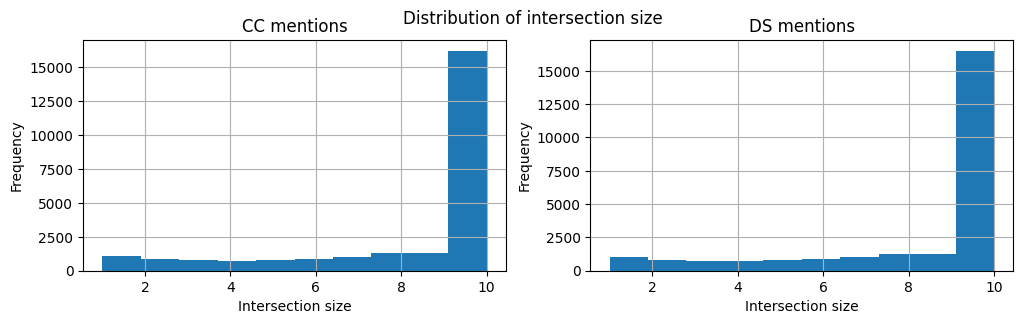

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

df_inter_cc[df_inter_cc["inter_size"] > 0].inter_size.hist(ax=ax[0], bins=10)
ax[0].set_title("CC mentions")
ax[0].set_xlabel("Intersection size")
ax[0].set_ylabel("Frequency")

df_inter_ds[df_inter_ds["inter_size"] > 0].inter_size.hist(ax=ax[1], bins=10)
ax[1].set_title("DS mentions")
ax[1].set_xlabel("Intersection size")
ax[1].set_ylabel("Frequency")
plt.suptitle("Distribution of intersection size")
# plt.savefig("img/automatic_metric/intersection_size.png", dpi=300, bbox_inches="tight")

In [18]:
df_n_mentions_cc = df_inter_cc.groupby("filenameid")["mention_id_cc"].nunique().reset_index()
df_n_mentions_ds = df_inter_ds.groupby("filenameid")["mention_id_ds"].nunique().reset_index()
df_n_mentions_cc.columns = ["filenameid", "n_mentions_cc"]
df_n_mentions_ds.columns = ["filenameid", "n_mentions_ds"]
df_n_mentions_cc

,filenameid,n_mentions_cc
0,25350173,29
1,25531204,39
2,25654384,55
3,25679083,35
4,25725033,22
...,...,...
995,38985686,22
996,39018148,32
997,39044225,27
998,39098903,24


In [19]:
df_n_mentions_ds

,filenameid,n_mentions_ds
0,25350173,26
1,25531204,36
2,25654384,51
3,25679083,37
4,25725033,28
...,...,...
995,38985686,24
996,39018148,33
997,39044225,25
998,39098903,32


In [20]:
print(df_inter_ds.mention_id_ds.nunique(), df_inter_cc.mention_id_cc.nunique())
print(df_inter_ds.shape, df_inter_cc.shape)

32122 33160
(32122, 12) (33160, 12)


In [21]:
df_inter_cc[df_inter_cc["inter_size"] == 2]

,label_cc,text_cc,filenameid,codes_cc,terms_cc,mention_id_cc,label_ds,text_ds,codes_ds,terms_ds,mention_id_ds,inter_size
81,DISEASE,severely dilated left ventricle,25350173,"[253541009, 840305006, 253541009, 6210001, 621...","[Dilatation of left cardiac ventricle, Severe ...",3717,DISEASE,Severely dilated left ventricle (LV) with a la...,"[297160003, 297160003, 297160003, 297160003, 2...","[Left ventricular aneurysm, LVA - Left ventric...",3798,2
189,DISEASE,arrhythmia,25350173,"[698247007, 698247007, 17366009, 44103008, 717...","[Arrhythmia, Cardiac arrhythmia, Atrial arrhyt...",3721,DISEASE,arrhythmogenic scar tissue,"[880040003, 735686002, 698247007, 253528005, 7...",[Arrhythmogenic left ventricular cardiomyopath...,3802,2
404,PROCEDURE,Percutaneous coronary intervention,25350173,"[415070008, 415070008, 405741001, 414089002, 8...","[Percutaneous coronary intervention, PCI - Per...",16459,PROCEDURE,Percutaneous coronary intervention was success...,"[868246006, 868246006, 1258931005, 868245005, ...",[Percutaneous coronary intervention of anterio...,16239,2
1382,PROCEDURE,inflammatory markers,25531204,"[49352002, 75777003, 32813003, 285319004, 1061...","[Mediator of inflammation, Cytokine, Cytokine ...",14327,PROCEDURE,markers,"[277565005, 468052006, 262308003, 391485008, 7...","[Radiology marker, Bone marker, Skin marker, C...",14243,2
9623,DISEASE,at,25878230,"[68504005, 35919005, 432414001, 68504005, 6850...","[Ataxia telangiectasia, Autism, Atonic constip...",8991,DISEASE,mild anemia,"[271737000, 271737000, 271737000, 370218001, 2...","[Anemia, Absolute anemia, Anaemia, Mild asthma...",9120,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1133390,SYMPTOM,pulmonary ven,38904301,"[304522008, 77892009, 304523003, 77892009, 128...","[Pulmonary vein finding, Pulmonary venous thro...",30192,SYMPTOM,Pulmonary venous congestion,"[304523003, 67599009, 8804002, 8804002, 638410...","[Pulmonary venous congestion, Pulmonary conges...",29216,2
1136772,SYMPTOM,",",38923781,"[64572001, 64572001, 52988006, 64572001, 64572...","[Diseases, Disease, Lesion, Disorder, Disorder...",32614,SYMPTOM,distress,"[69328002, 224977004, 224977004, 271596009, 24...","[Distress, Feeling distress, Distressed, Menta...",31498,2
1137003,SYMPTOM,left ventricle with normal size,38923781,"[414072005, 373124004, 53461003, 53461003, 371...",[Echocardiogram shows normal left ventricular ...,32619,SYMPTOM,normal vital signs,"[72970002, 64826008, 118227000, 39968002, 5346...","[Normal vital signs, Normal blood volume, Vita...",31499,2
1141428,PROCEDURE,transthoracic echocardiography,39044225,"[433236007, 105376000, 105376000, 105376000, 7...","[Transthoracic echocardiography, Transesophage...",21805,PROCEDURE,Echocardiography,"[40701008, 40701008, 40701008, 40701008, 43323...","[Echocardiography, Echocardiogram, Echocardiog...",21258,2


(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)


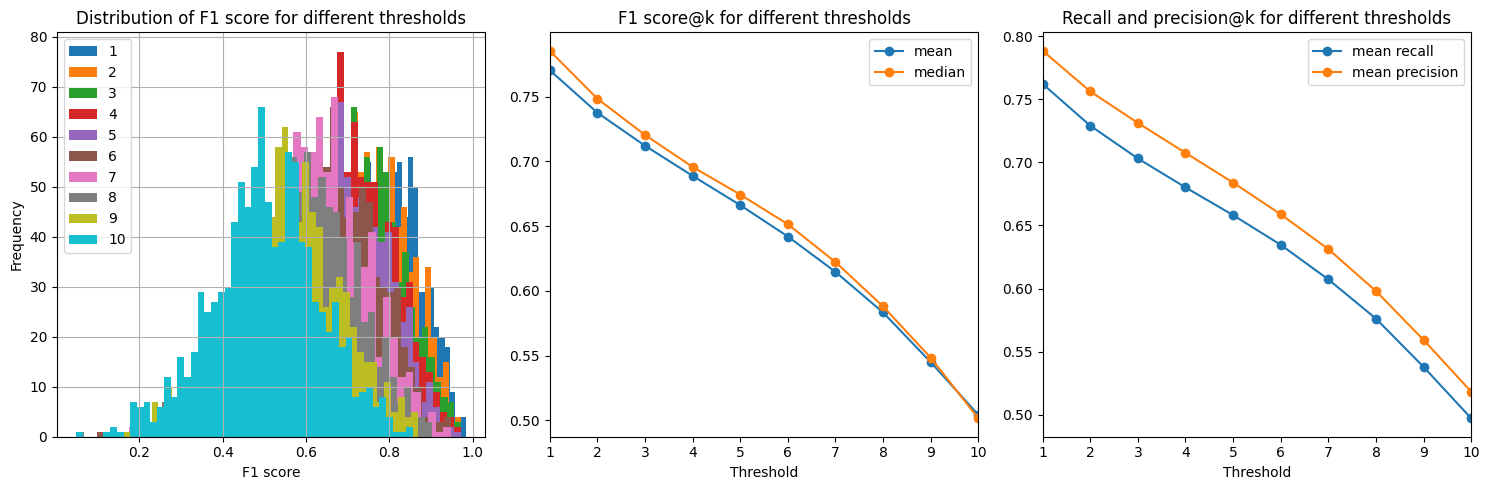

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ls_thres = list(range(1, 11))
ls_mean = []
ls_median = []
ls_mean_recall = []
ls_mean_precision = []
for threshold in ls_thres:
    df_aux_cc = df_inter_cc.copy()
    df_aux_cc["inter_size"] = df_aux_cc.apply(lambda x: len(set(x["terms_cc"]).intersection(set(x["terms_ds"]))), axis=1)
    df_aux_cc["top_rank"] = df_aux_cc.apply(lambda x: min([x["terms_cc"].index(y) if y in x["terms_cc"] else 999 for y in x["terms_ds"]]), axis=1)

    df_aux_cc.loc[:, "tp"] = df_aux_cc.apply(lambda x: 1 if (x["inter_size"] >= threshold)&(x["label_cc"] == x["label_ds"]) else 0, axis=1)
    
    df_aux_ds = df_inter_ds.copy()
    df_aux_ds["inter_size"] = df_aux_ds.apply(lambda x: len(set(x["terms_cc"]).intersection(set(x["terms_ds"]))), axis=1)
    df_aux_ds["top_rank"] = df_aux_ds.apply(lambda x: min([x["terms_ds"].index(y) if y in x["terms_ds"] else 999 for y in x["terms_cc"]]), axis=1)
    df_aux_ds.loc[:, "tp"] = df_aux_ds.apply(lambda x: 1 if (x["inter_size"] >= threshold)&(x["label_cc"] == x["label_ds"]) else 0, axis=1)

    df_auto_score_cc = df_aux_cc.groupby("filenameid")["tp"].sum().reset_index()
    df_auto_score_cc = df_auto_score_cc.merge(df_n_mentions_cc, on="filenameid", how="left")
    # df_auto_score_cc = df_auto_score_cc.rename(columns={"tp": "tp_cc"})
    df_auto_score_cc = df_auto_score_cc.fillna(0)
    
    df_auto_score_ds = df_aux_ds.groupby("filenameid")["tp"].sum().reset_index()
    df_auto_score_ds = df_auto_score_ds.merge(df_n_mentions_ds, on="filenameid", how="left")
    # df_auto_score_ds = df_auto_score_ds.rename(columns={"tp": "tp_ds"})
    df_auto_score_ds = df_auto_score_ds.fillna(0)

    print(df_auto_score_cc.shape, df_auto_score_ds.shape)
    
    df_auto_score = df_auto_score_cc.merge(df_auto_score_ds, on="filenameid", how="left", suffixes=("_cc", "_ds"))
    df_auto_score["precision"] = df_auto_score["tp_ds"] / df_auto_score["n_mentions_ds"]
    df_auto_score["recall"] = df_auto_score["tp_cc"] / df_auto_score["n_mentions_cc"]
    df_auto_score["f1"] = 2 * df_auto_score["precision"] * df_auto_score["recall"] / (df_auto_score["precision"] + df_auto_score["recall"])

    df_auto_score["f1"].hist(bins=50, label=str(threshold), ax=ax[0])
    

    ax[0].set_title("Distribution of F1 score for different thresholds")
    ax[0].set_xlabel("F1 score")
    ax[0].set_ylabel("Frequency")
    ax[0].legend()
    
    ls_mean.append(df_auto_score["f1"].mean())
    ls_median.append(df_auto_score["f1"].median())
    
    ls_mean_recall.append(df_auto_score["recall"].mean())
    ls_mean_precision.append(df_auto_score["precision"].mean())
    
ax[1].plot(ls_thres, ls_mean, label="mean", marker="o")
ax[1].plot(ls_thres, ls_median, label="median", marker="o")
ax[1].set_title("F1 score@k for different thresholds")
ax[1].set_xlabel("Threshold")
ax[1].set_xlim(1, 10)
ax[1].legend()

ax[2].plot(ls_thres, ls_mean_recall, label="mean recall", marker="o")
ax[2].plot(ls_thres, ls_mean_precision, label="mean precision", marker="o")
ax[2].set_title("Recall and precision@k for different thresholds")
ax[2].set_xlabel("Threshold")
ax[2].set_xlim(1, 10)
ax[2].legend()

plt.tight_layout()
# plt.savefig("img/automatic_metric/threshold_analysis.png", dpi=300, bbox_inches="tight")

Observed 8 as a good threshold

In [24]:
df_inter_cc["top_rank"] = df_inter_cc.apply(lambda x: min([x["terms_cc"].index(y) + 1 if y in x["terms_cc"] else 999 for y in x["terms_ds"]]), axis=1)
df_inter_ds["top_rank"] = df_inter_ds.apply(lambda x: min([x["terms_ds"].index(y) + 1 if y in x["terms_ds"] else 999 for y in x["terms_cc"]]), axis=1)

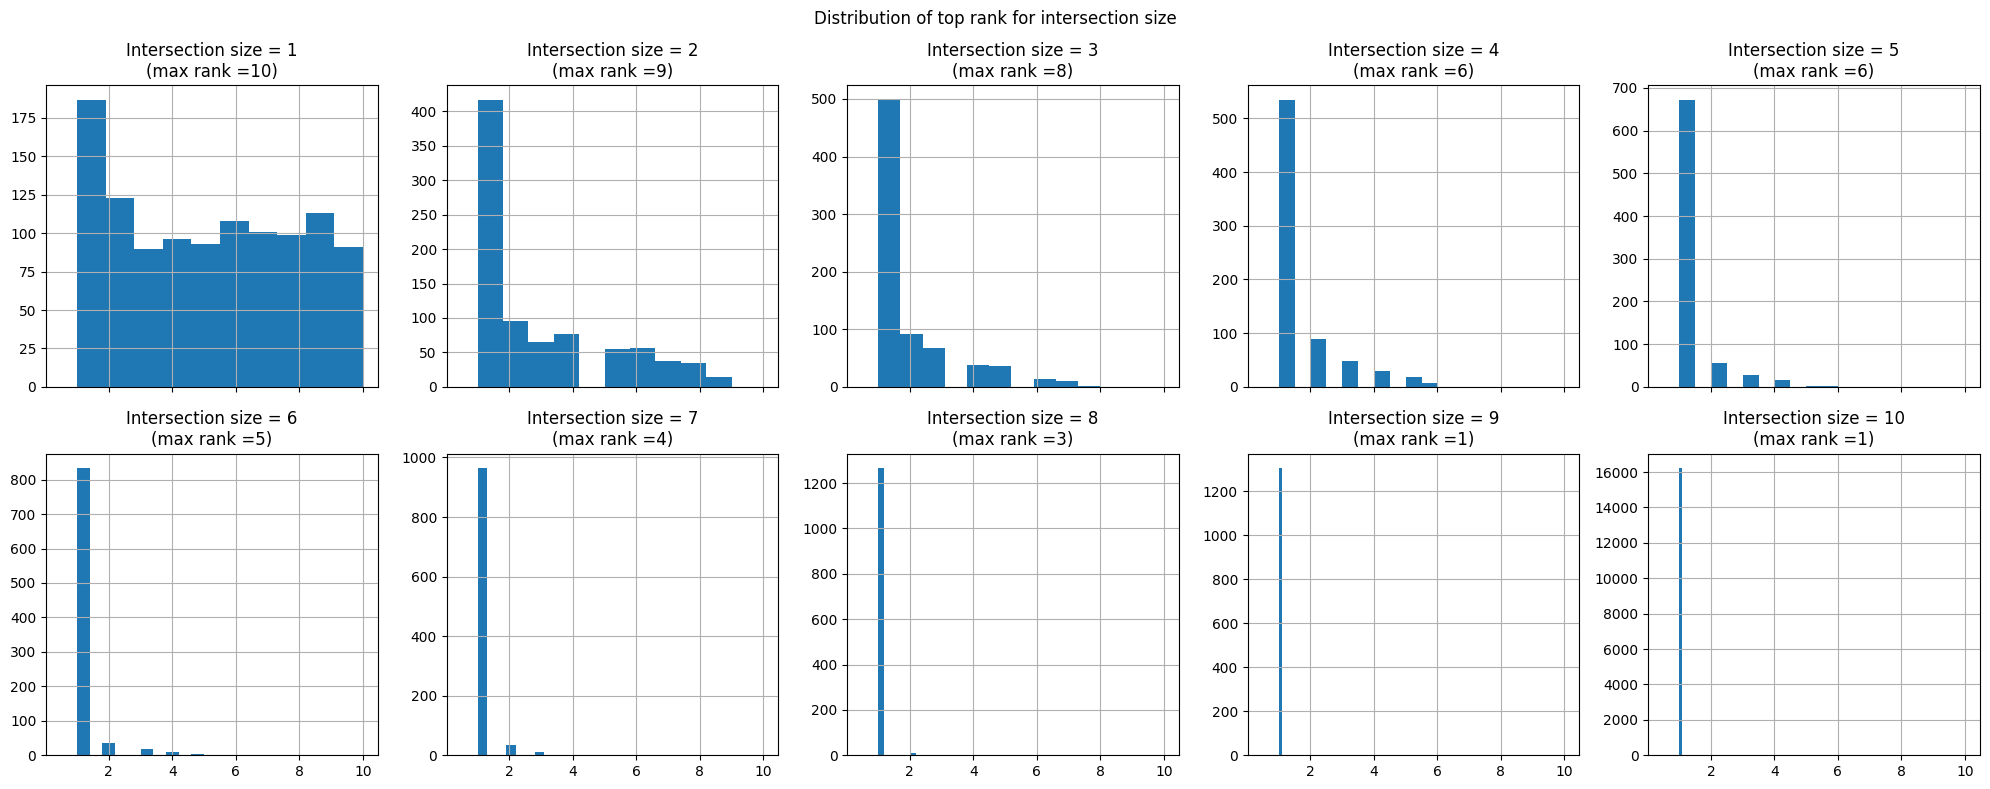

In [25]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8), sharex=True)
axx = ax.flatten()
for pos in range(1, 11):
    ranks = df_inter_cc[(df_inter_cc["inter_size"] == pos)&(df_inter_cc["top_rank"] < 999)].top_rank
    ranks.hist(label=str(pos), ax=axx[pos-1], bins=10)
    axx[pos-1].set_title("Intersection size = " + str(pos) + "\n(max rank =" + str(ranks.max()) + ")")

plt.suptitle("Distribution of top rank for intersection size")
plt.tight_layout()

In [38]:
import  numpy as np

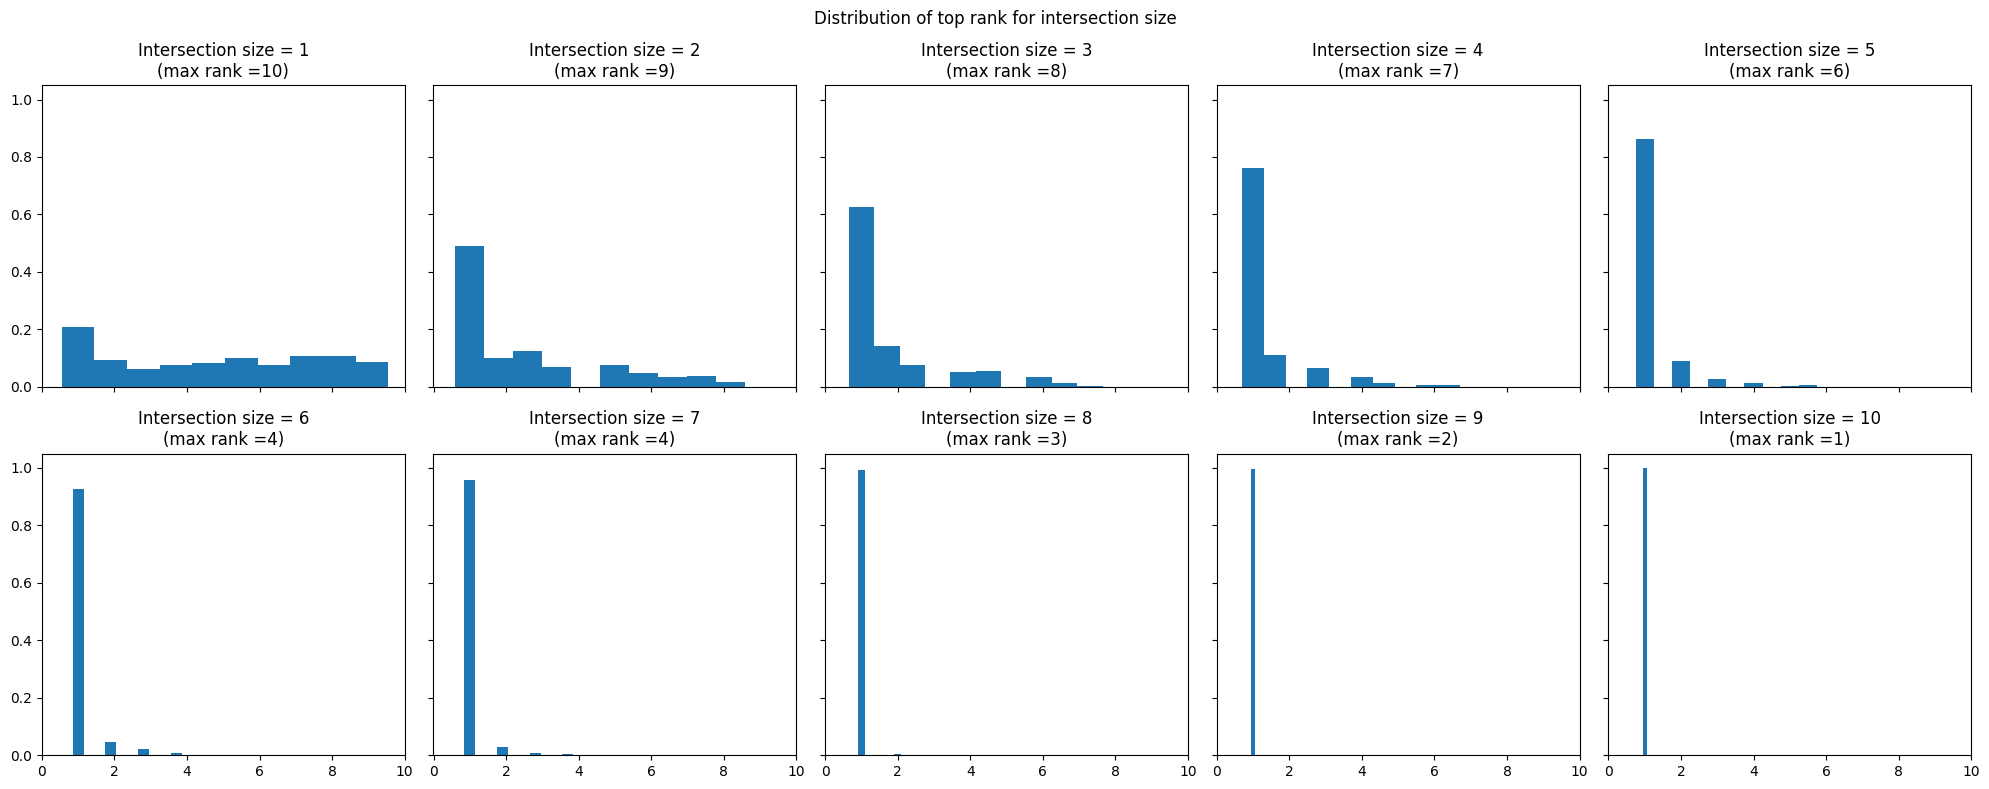

In [42]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8), sharex=True, sharey=True)
axx = ax.flatten()
for pos in range(1, 11):
    ranks = df_inter_ds[(df_inter_ds["inter_size"] == pos)&(df_inter_ds["top_rank"] < 999)].top_rank
    hist, bins = np.histogram(ranks, bins=10)
    
    # ranks.hist(label=str(pos), ax=axx[pos-1], bins=10)
    axx[pos-1].bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]))

    axx[pos-1].set_title("Intersection size = " + str(pos) + "\n(max rank =" + str(ranks.max()) + ")")

plt.suptitle("Distribution of top rank for intersection size")
plt.tight_layout()
plt.savefig("img/automatic_metric/top_rank_threshold.png", dpi=300, bbox_inches="tight")

In [32]:
threshold = 7

df_inter_cc.loc[:, "tp"] = df_inter_cc.apply(lambda x: int(x["inter_size"] >= threshold), axis=1)
df_inter_ds.loc[:, "tp"] = df_inter_ds.apply(lambda x: int(x["inter_size"] >= threshold), axis=1)

# df_inter_cc[df_inter_cc["filenameid"] == "30180978_3"]

df_inter_cc[df_inter_cc["tp"] == 1]

,label_cc,text_cc,filenameid,codes_cc,terms_cc,mention_id_cc,label_ds,text_ds,codes_ds,terms_ds,mention_id_ds,inter_size,top_rank,tp
0,DISEASE,smoker,25350173,"[77176002, 65568007, 230065006, 77176002, 7717...","[Smoker, Cigarette smoker, Chain smoker, Smoki...",3714,DISEASE,smoker,"[77176002, 65568007, 230065006, 77176002, 7717...","[Smoker, Cigarette smoker, Chain smoker, Smoki...",3795,10,1,1
27,DISEASE,monophasic ventricular tachycardia,25350173,"[251158004, 25569003, 1237128001, 25569003, 11...","[Ventricular tachycardia, monomorphic, Ventric...",3715,DISEASE,monophasic ventricular tachycardia,"[251158004, 25569003, 1237128001, 25569003, 11...","[Ventricular tachycardia, monomorphic, Ventric...",3796,10,1,1
54,DISEASE,VT,25350173,"[25569003, 25569003, 111852003, 82515000, 2339...","[VT - ventricular tachycardia, Ventricular tac...",3716,DISEASE,VT,"[25569003, 25569003, 111852003, 82515000, 2339...","[VT - ventricular tachycardia, Ventricular tac...",3797,10,1,1
107,DISEASE,LV) with a large aneurysm,25350173,"[297160003, 297160003, 297160003, 253544001, 2...","[Left ventricular aneurysm, LVA - Left ventric...",3718,DISEASE,Severely dilated left ventricle (LV) with a la...,"[297160003, 297160003, 297160003, 297160003, 2...","[Left ventricular aneurysm, LVA - Left ventric...",3798,7,1,1
215,DISEASE,the arrhythmogenic scar tissue,25350173,"[880040003, 735686002, 75403004, 253528005, 69...",[Arrhythmogenic left ventricular cardiomyopath...,3722,DISEASE,arrhythmogenic scar tissue,"[880040003, 735686002, 698247007, 253528005, 7...",[Arrhythmogenic left ventricular cardiomyopath...,3802,9,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143777,PROCEDURE,Heart valve intervention,39101327,"[119767007, 112815000, 307799000, 73544002, 11...","[Heart valve injection, Implantation of heart ...",21270,PROCEDURE,Heart valve intervention,"[119767007, 112815000, 307799000, 73544002, 11...","[Heart valve injection, Implantation of heart ...",20738,10,1,1
1143890,SYMPTOM,anasarca,39101327,"[16740003, 442433009, 74011000119107, 48257004...","[Anasarca, Anasarca, Renal anasarca, Anarthria...",31217,SYMPTOM,anasarca,"[16740003, 442433009, 74011000119107, 48257004...","[Anasarca, Anasarca, Renal anasarca, Anarthria...",30154,8,1,1
1143929,SYMPTOM,severely reduced right heart function,39101327,"[39589002, 367363000, 367363000, 473365008, 47...","[Hypoplasia of right heart, Right heart failur...",31218,SYMPTOM,severely reduced right heart function,"[39589002, 367363000, 367363000, 473365008, 47...","[Hypoplasia of right heart, Right heart failur...",30156,10,1,1
1143967,SYMPTOM,left ventricular chamber size was enlarged,39101327,"[373128001, 93053007, 373126002, 93051009, 253...","[Markedly enlarged cardiac chamber, Congenital...",31219,SYMPTOM,enlarged left ventricular chamber,"[93053007, 373128001, 93051009, 373126002, 253...","[Congenital enlarged ventricular chamber, Mark...",30157,7,1,1


In [48]:
example = df_inter_cc[(df_inter_cc["inter_size"] == 5)&(df_inter_cc["top_rank"] == 3)].iloc[1]
example

label_cc                                                 PROCEDURE
text_cc                        3D-transesophageal echocardiography
filenameid                                                29558902
codes_cc         [445864005, 445864005, 105376000, 445864005, 1...
terms_cc         [Three dimensional transesophageal echocardiog...
mention_id_cc                                                19522
label_ds                                                 PROCEDURE
text_ds                             Transthoracic Echocardiography
codes_ds         [433236007, 105376000, 105376000, 105376000, 7...
terms_ds         [Transthoracic echocardiography, Transesophage...
mention_id_ds                                                19138
inter_size                                                       5
top_rank                                                         3
tp                                                               1
Name: 78539, dtype: object

In [50]:
list(set(example["terms_cc"]).intersection(set(example["terms_ds"])))

['Transesophageal echocardiogram',
 'Transoesophageal echocardiography',
 'Doppler transesophageal echocardiography',
 'Transesophageal echocardiography',
 'TOE - Transesophageal echocardiography']

In [33]:
threshold = 6

df_inter_cc.loc[:, "tp"] = df_inter_cc.apply(lambda x: int(x["inter_size"] >= threshold), axis=1)
df_inter_ds.loc[:, "tp"] = df_inter_ds.apply(lambda x: int(x["inter_size"] >= threshold), axis=1)

# df_inter_cc[df_inter_cc["filenameid"] == "30180978_3"]

df_inter_cc[df_inter_cc["tp"] == 1]

,label_cc,text_cc,filenameid,codes_cc,terms_cc,mention_id_cc,label_ds,text_ds,codes_ds,terms_ds,mention_id_ds,inter_size,top_rank,tp
0,DISEASE,smoker,25350173,"[77176002, 65568007, 230065006, 77176002, 7717...","[Smoker, Cigarette smoker, Chain smoker, Smoki...",3714,DISEASE,smoker,"[77176002, 65568007, 230065006, 77176002, 7717...","[Smoker, Cigarette smoker, Chain smoker, Smoki...",3795,10,1,1
27,DISEASE,monophasic ventricular tachycardia,25350173,"[251158004, 25569003, 1237128001, 25569003, 11...","[Ventricular tachycardia, monomorphic, Ventric...",3715,DISEASE,monophasic ventricular tachycardia,"[251158004, 25569003, 1237128001, 25569003, 11...","[Ventricular tachycardia, monomorphic, Ventric...",3796,10,1,1
54,DISEASE,VT,25350173,"[25569003, 25569003, 111852003, 82515000, 2339...","[VT - ventricular tachycardia, Ventricular tac...",3716,DISEASE,VT,"[25569003, 25569003, 111852003, 82515000, 2339...","[VT - ventricular tachycardia, Ventricular tac...",3797,10,1,1
107,DISEASE,LV) with a large aneurysm,25350173,"[297160003, 297160003, 297160003, 253544001, 2...","[Left ventricular aneurysm, LVA - Left ventric...",3718,DISEASE,Severely dilated left ventricle (LV) with a la...,"[297160003, 297160003, 297160003, 297160003, 2...","[Left ventricular aneurysm, LVA - Left ventric...",3798,7,1,1
215,DISEASE,the arrhythmogenic scar tissue,25350173,"[880040003, 735686002, 75403004, 253528005, 69...",[Arrhythmogenic left ventricular cardiomyopath...,3722,DISEASE,arrhythmogenic scar tissue,"[880040003, 735686002, 698247007, 253528005, 7...",[Arrhythmogenic left ventricular cardiomyopath...,3802,9,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143929,SYMPTOM,severely reduced right heart function,39101327,"[39589002, 367363000, 367363000, 473365008, 47...","[Hypoplasia of right heart, Right heart failur...",31218,SYMPTOM,severely reduced right heart function,"[39589002, 367363000, 367363000, 473365008, 47...","[Hypoplasia of right heart, Right heart failur...",30156,10,1,1
1143967,SYMPTOM,left ventricular chamber size was enlarged,39101327,"[373128001, 93053007, 373126002, 93051009, 253...","[Markedly enlarged cardiac chamber, Congenital...",31219,SYMPTOM,enlarged left ventricular chamber,"[93053007, 373128001, 93051009, 373126002, 253...","[Congenital enlarged ventricular chamber, Mark...",30157,7,1,1
1144080,SYMPTOM,) in,39101327,"[161056001, 315444002, 2438005, 77599005, 7759...","[In care, Born in India, Iniencephaly, Toeing-...",31222,SYMPTOM,in,"[161056001, 2438005, 127569003, 315444002, 775...","[In care, Iniencephaly, In situ neoplasm, Born...",30159,6,1,1
1144118,SYMPTOM,were negative,39101327,"[278154007, 442225006, 168386007, 309306009, 1...","[Group AB neg, Negative measurement finding, C...",31223,SYMPTOM,: Negative,"[442225006, 278154007, 225462008, 165746003, 3...","[Negative measurement finding, Group AB neg, N...",30160,6,1,1


In [44]:

df_auto_score_cc = df_inter_cc.groupby("filenameid")["tp"].sum().reset_index()
df_auto_score_cc = df_auto_score_cc.merge(df_n_mentions_cc, on="filenameid", how="left")
# df_auto_score_cc = df_auto_score_cc.rename(columns={"tp": "tp_cc"})
df_auto_score_cc = df_auto_score_cc.fillna(0)

df_auto_score_ds = df_inter_ds.groupby("filenameid")["tp"].sum().reset_index()
df_auto_score_ds = df_auto_score_ds.merge(df_n_mentions_ds, on="filenameid", how="left")
# df_auto_score_ds = df_auto_score_ds.rename(columns={"tp": "tp_ds"})
df_auto_score_ds = df_auto_score_ds.fillna(0)

print(df_auto_score_cc.shape, df_auto_score_ds.shape)

df_auto_score = df_auto_score_cc.merge(df_auto_score_ds, on="filenameid", how="left", suffixes=("_cc", "_ds"))
df_auto_score["precision"] = df_auto_score["tp_ds"] / df_auto_score["n_mentions_ds"]
df_auto_score["recall"] = df_auto_score["tp_cc"] / df_auto_score["n_mentions_cc"]
df_auto_score["f1"] = 2 * df_auto_score["precision"] * df_auto_score["recall"] / (df_auto_score["precision"] + df_auto_score["recall"])
df_auto_score = df_auto_score.sort_values(by="f1", ascending=False).reset_index(drop=True).fillna(0)
df_auto_score

(1000, 3) (1000, 3)


,filenameid,tp_cc,n_mentions_cc,tp_ds,n_mentions_ds,precision,recall,f1
0,26512038,10,10,9,10,0.900000,1.000000,0.947368
1,34946264,21,23,22,23,0.956522,0.913043,0.934277
2,30628903,16,18,16,17,0.941176,0.888889,0.914286
3,30567249,11,11,15,18,0.833333,1.000000,0.909091
4,30971480_1,21,22,24,28,0.857143,0.954545,0.903226
...,...,...,...,...,...,...,...,...
995,39044225,6,27,6,25,0.240000,0.222222,0.230769
996,31974261,9,51,9,49,0.183673,0.176471,0.180000
997,38541118,8,41,7,42,0.166667,0.195122,0.179775
998,35456383,5,33,5,42,0.119048,0.151515,0.133333


In [45]:
df_n_mentions_cc_label = df_inter_cc.groupby(["filenameid", "label_cc"])["mention_id_cc"].nunique().reset_index().rename(columns={"label_cc": "label",
                                                                                                                                  "mention_id_cc": "n_mentions_cc"})
df_n_mentions_ds_label = df_inter_ds.groupby(["filenameid", "label_ds"])["mention_id_ds"].nunique().reset_index().rename(columns={"label_ds": "label",
                                                                                                                                    "mention_id_ds": "n_mentions_ds"})

df_auto_score_cc_label = df_inter_cc.groupby(["filenameid", "label_cc"])["tp"].sum().reset_index().rename(columns={"label_cc": "label"})
df_auto_score_cc_label = df_auto_score_cc_label.merge(df_n_mentions_cc_label, on=["filenameid", "label"], how="left")
# df_auto_score_cc = df_auto_score_cc.rename(columns={"tp": "tp_cc"})
df_auto_score_cc_label = df_auto_score_cc_label.fillna(0)

df_auto_score_ds_label = df_inter_ds.groupby(["filenameid", "label_ds"])["tp"].sum().reset_index().rename(columns={"label_ds": "label"})
df_auto_score_ds_label = df_auto_score_ds_label.merge(df_n_mentions_ds_label, on=["filenameid", "label"], how="left")
# df_auto_score_cc = df_auto_score_cc.rename(columns={"tp": "tp_cc"})
df_auto_score_ds_label = df_auto_score_ds_label.fillna(0)

print(df_auto_score_cc_label.shape, df_auto_score_ds_label.shape)

df_auto_score_label = df_auto_score_cc_label.merge(df_auto_score_ds_label, on=["filenameid", "label"], how="left", suffixes=("_cc", "_ds"))
df_auto_score_label["precision"] = df_auto_score_label["tp_ds"] / df_auto_score_label["n_mentions_ds"]
df_auto_score_label["recall"] = df_auto_score_label["tp_cc"] / df_auto_score_label["n_mentions_cc"]
df_auto_score_label["f1"] = 2 * df_auto_score_label["precision"] * df_auto_score_label["recall"] / (df_auto_score_label["precision"] + df_auto_score_label["recall"])
df_auto_score_label = df_auto_score_label.sort_values(by="f1", ascending=False).reset_index(drop=True).fillna(0)

df_auto_score_label.sort_values(by=["filenameid", "label"], inplace=True)
df_auto_score_label 

(3487, 4) (3487, 4)


,filenameid,label,tp_cc,n_mentions_cc,tp_ds,n_mentions_ds,precision,recall,f1
2042,25350173,DISEASE,5,9,5,8,0.625000,0.555556,0.588235
302,25350173,MEDICATION,2,2,2,2,1.000000,1.000000,1.000000
2133,25350173,PROCEDURE,8,15,8,13,0.615385,0.533333,0.571429
0,25350173,SYMPTOM,3,3,3,3,1.000000,1.000000,1.000000
847,25531204,DISEASE,8,11,8,9,0.888889,0.727273,0.800000
...,...,...,...,...,...,...,...,...,...
1025,39098903,SYMPTOM,3,4,3,4,0.750000,0.750000,0.750000
1005,39101327,DISEASE,9,12,10,13,0.769231,0.750000,0.759494
1,39101327,MEDICATION,9,9,8,8,1.000000,1.000000,1.000000
657,39101327,PROCEDURE,8,10,7,8,0.875000,0.800000,0.835821


In [46]:
df_auto_score_label.groupby("label")[["precision", "recall", "f1"]].mean().sort_values(by="f1", ascending=False)

,precision,recall,f1
label,,,
MEDICATION,0.832666,0.814223,0.799698
DISEASE,0.678862,0.661465,0.657200
SYMPTOM,0.598093,0.566309,0.565185
PROCEDURE,0.581148,0.572751,0.563878


In [47]:
print(df_auto_score_label[df_auto_score_label["precision"] > 1])
print(df_auto_score_label[df_auto_score_label["recall"] > 1])
print(df_auto_score_label[df_auto_score_label["f1"] > 1])

Empty DataFrame
Columns: [filenameid, label, tp_cc, n_mentions_cc, tp_ds, n_mentions_ds, precision, recall, f1]
Index: []
Empty DataFrame
Columns: [filenameid, label, tp_cc, n_mentions_cc, tp_ds, n_mentions_ds, precision, recall, f1]
Index: []
Empty DataFrame
Columns: [filenameid, label, tp_cc, n_mentions_cc, tp_ds, n_mentions_ds, precision, recall, f1]
Index: []


In [48]:
bottom_5 = df_auto_score.sort_values(by="f1", ascending=True).head(5).filenameid.tolist()
top_5 = df_auto_score.sort_values(by="f1", ascending=False).head(5).filenameid.tolist()

In [49]:
df_auto_score.sort_values(by="f1", ascending=False).head(5)

,filenameid,tp_cc,n_mentions_cc,tp_ds,n_mentions_ds,precision,recall,f1
0,26512038,10,10,9,10,0.900000,1.000000,0.947368
1,34946264,21,23,22,23,0.956522,0.913043,0.934277
2,30628903,16,18,16,17,0.941176,0.888889,0.914286
3,30567249,11,11,15,18,0.833333,1.000000,0.909091
4,30971480_1,21,22,24,28,0.857143,0.954545,0.903226


In [50]:
df_auto_score.sort_values(by="f1", ascending=True).head(5)

,filenameid,tp_cc,n_mentions_cc,tp_ds,n_mentions_ds,precision,recall,f1
999,34310587,1,20,1,21,0.047619,0.050000,0.048780
998,35456383,5,33,5,42,0.119048,0.151515,0.133333
997,38541118,8,41,7,42,0.166667,0.195122,0.179775
996,31974261,9,51,9,49,0.183673,0.176471,0.180000
995,39044225,6,27,6,25,0.240000,0.222222,0.230769


In [57]:
df_pair

NameError: name 'df_pair' is not defined

In [54]:
df_inter_cc[df_inter_cc["filenameid"].isin([top_5[0]])]

,label_cc,text_cc,filenameid,codes_cc,terms_cc,mention_id_cc,label_ds,text_ds,codes_ds,terms_ds,mention_id_ds,inter_size,top_rank,tp
16302,DISEASE,acute heart failure,26512038,"[56675007, 10633002, 27942005, 364006, 1951140...","[Acute heart failure, Acute congestive heart f...",9588,DISEASE,acute heart failure,"[56675007, 10633002, 27942005, 364006, 1951140...","[Acute heart failure, Acute congestive heart f...",9725,10,0,1
16313,DISEASE,ruptured sinus of Valsalva aneurysm entering i...,26512038,"[448746009, 35162007, 253648009, 448745008, 33...",[Aneurysm of aortic sinus of Valsalva with rup...,9589,DISEASE,ruptured sinus of Valsalva aneurysm extending ...,"[448746009, 253648009, 448745008, 35162007, 33...",[Aneurysm of aortic sinus of Valsalva with rup...,9726,9,0,1
16324,DISEASE,windsock deformity,26512038,"[205269007, 784268004, 771263004, 13206009, 39...","[Windblown hand, Windswept hip deformity, Tuck...",9590,DISEASE,windsock deformity,"[205269007, 784268004, 771263004, 13206009, 39...","[Windblown hand, Windswept hip deformity, Tuck...",9727,10,0,1
16336,DISEASE,shunt,26512038,"[125319009, 128617001, 238162006, 41796003, 12...","[Shunt, Arteriovenous shunt, Tissue shunting, ...",9591,DISEASE,shunt,"[125319009, 128617001, 238162006, 41796003, 12...","[Shunt, Arteriovenous shunt, Tissue shunting, ...",9729,9,0,1
16347,PROCEDURE,Transthoracic echocardiogram,26512038,"[433236007, 105376000, 105376000, 105376000, 1...","[Transthoracic echocardiography, Transesophage...",23034,PROCEDURE,transthoracic echocardiogram,"[433236007, 105376000, 105376000, 105376000, 1...","[Transthoracic echocardiography, Transesophage...",22458,10,0,1
16358,PROCEDURE,Angiogram,26512038,"[77343006, 77343006, 33367005, 77343006, 12911...","[Angiogram, Angiography, Coronary angiogram, D...",23035,PROCEDURE,angiogram,"[77343006, 77343006, 33367005, 77343006, 12911...","[Angiogram, Angiography, Coronary angiogram, D...",22459,10,0,1
16369,PROCEDURE,device closure,26512038,"[112695004, 112695004, 120167008, 119759004, 3...","[Closure, Surgical closure, Diaphragm closure,...",23036,PROCEDURE,device closure,"[112695004, 112695004, 120167008, 119759004, 3...","[Closure, Surgical closure, Diaphragm closure,...",22460,10,0,1
16380,PROCEDURE,LIFETECH CERA PDA occlusion device,26512038,"[441676000, 360130004, 60911000119109, 4416760...",[Occlusion of patent ductus arteriosus using e...,23037,PROCEDURE,a 10/12 mm LIFETECH CERA PDA occlusion device,"[441676000, 175218000, 360130004, 265859004, 2...",[Occlusion of patent ductus arteriosus using e...,22461,7,0,1
16388,PROCEDURE,angiogram,26512038,"[77343006, 77343006, 33367005, 77343006, 12911...","[Angiogram, Angiography, Coronary angiogram, D...",23038,PROCEDURE,angiogram,"[77343006, 77343006, 33367005, 77343006, 12911...","[Angiogram, Angiography, Coronary angiogram, D...",22459,10,0,1
16401,PROCEDURE,echocardiogram,26512038,"[40701008, 40701008, 40701008, 40701008, 43323...","[Echocardiogram, Echocardiography, Echocardiog...",23039,PROCEDURE,echocardiogram,"[40701008, 40701008, 40701008, 40701008, 43323...","[Echocardiogram, Echocardiography, Echocardiog...",22462,10,0,1


In [55]:
df_inter_ds[df_inter_ds["filenameid"].isin([top_5[0]])]

,label_cc,text_cc,filenameid,codes_cc,terms_cc,mention_id_cc,label_ds,text_ds,codes_ds,terms_ds,mention_id_ds,inter_size,top_rank,tp
16302,DISEASE,acute heart failure,26512038,"[56675007, 10633002, 27942005, 364006, 1951140...","[Acute heart failure, Acute congestive heart f...",9588,DISEASE,acute heart failure,"[56675007, 10633002, 27942005, 364006, 1951140...","[Acute heart failure, Acute congestive heart f...",9725,10,0,1
16313,DISEASE,ruptured sinus of Valsalva aneurysm entering i...,26512038,"[448746009, 35162007, 253648009, 448745008, 33...",[Aneurysm of aortic sinus of Valsalva with rup...,9589,DISEASE,ruptured sinus of Valsalva aneurysm extending ...,"[448746009, 253648009, 448745008, 35162007, 33...",[Aneurysm of aortic sinus of Valsalva with rup...,9726,9,0,1
16324,DISEASE,windsock deformity,26512038,"[205269007, 784268004, 771263004, 13206009, 39...","[Windblown hand, Windswept hip deformity, Tuck...",9590,DISEASE,windsock deformity,"[205269007, 784268004, 771263004, 13206009, 39...","[Windblown hand, Windswept hip deformity, Tuck...",9727,10,0,1
16305,DISEASE,acute heart failure,26512038,"[56675007, 10633002, 27942005, 364006, 1951140...","[Acute heart failure, Acute congestive heart f...",9588,DISEASE,aneurysm,"[85659009, 432119003, 233981004, 128609009, 12...","[Aneurysm, Aneurysm, Arterial aneurysm, Cerebr...",9728,0,999,0
16336,DISEASE,shunt,26512038,"[125319009, 128617001, 238162006, 41796003, 12...","[Shunt, Arteriovenous shunt, Tissue shunting, ...",9591,DISEASE,shunt,"[125319009, 128617001, 238162006, 41796003, 12...","[Shunt, Arteriovenous shunt, Tissue shunting, ...",9729,9,0,1
16347,PROCEDURE,Transthoracic echocardiogram,26512038,"[433236007, 105376000, 105376000, 105376000, 1...","[Transthoracic echocardiography, Transesophage...",23034,PROCEDURE,transthoracic echocardiogram,"[433236007, 105376000, 105376000, 105376000, 1...","[Transthoracic echocardiography, Transesophage...",22458,10,0,1
16358,PROCEDURE,Angiogram,26512038,"[77343006, 77343006, 33367005, 77343006, 12911...","[Angiogram, Angiography, Coronary angiogram, D...",23035,PROCEDURE,angiogram,"[77343006, 77343006, 33367005, 77343006, 12911...","[Angiogram, Angiography, Coronary angiogram, D...",22459,10,0,1
16369,PROCEDURE,device closure,26512038,"[112695004, 112695004, 120167008, 119759004, 3...","[Closure, Surgical closure, Diaphragm closure,...",23036,PROCEDURE,device closure,"[112695004, 112695004, 120167008, 119759004, 3...","[Closure, Surgical closure, Diaphragm closure,...",22460,10,0,1
16380,PROCEDURE,LIFETECH CERA PDA occlusion device,26512038,"[441676000, 360130004, 60911000119109, 4416760...",[Occlusion of patent ductus arteriosus using e...,23037,PROCEDURE,a 10/12 mm LIFETECH CERA PDA occlusion device,"[441676000, 175218000, 360130004, 265859004, 2...",[Occlusion of patent ductus arteriosus using e...,22461,7,0,1
16401,PROCEDURE,echocardiogram,26512038,"[40701008, 40701008, 40701008, 40701008, 43323...","[Echocardiogram, Echocardiography, Echocardiog...",23039,PROCEDURE,echocardiogram,"[40701008, 40701008, 40701008, 40701008, 43323...","[Echocardiogram, Echocardiography, Echocardiog...",22462,10,0,1


In [53]:
df_inter_cc[df_inter_cc["filenameid"].isin([bottom_5[1]])]

,label_cc,text_cc,filenameid,codes_cc,terms_cc,mention_id_cc,label_ds,text_ds,codes_ds,terms_ds,mention_id_ds,inter_size,top_rank,tp
828908,DISEASE,fatal stroke,35456383,"[230690007, 25133001, 26636000, 230802007, 373...","[Stroke, Completed stroke, Sudden death, Brain...",2280,DISEASE,stroke,"[230690007, 422504002, 422504002, 25133001, 28...","[Stroke, Ischemic stroke, Ischaemic stroke, Co...",2305,4,0,0
828975,PROCEDURE,clinical examination,35456383,"[5880005, 5880005, 410183009, 5880005, 5880005...","[Clinical examination, Physical examination, C...",14812,PROCEDURE,ECG,"[29303009, 29303009, 29303009, 46136006, 29303...","[Electrocardiogram, Electrocardiography proced...",14702,0,999,0
829018,PROCEDURE,collection of venous blood samples for DNA-dia...,35456383,"[16631761000119104, 396540005, 28520004, 28520...",[Collection of blood via implanted venous acce...,14813,PROCEDURE,ECG,"[29303009, 29303009, 29303009, 46136006, 29303...","[Electrocardiogram, Electrocardiography proced...",14702,0,999,0
829066,PROCEDURE,blood tests,35456383,"[396550006, 15220000, 165349007, 252314007, 41...","[Blood test, Laboratory test, Blood test due, ...",14814,PROCEDURE,Tests,"[15220000, 396550006, 38038000, 1999007, 33738...","[Laboratory test, Blood test, Tolerance test, ...",14707,2,0,0
829104,PROCEDURE,full blood count,35456383,"[26604007, 26604007, 26604007, 391558003, 8830...","[FBC - Full blood count, Complete blood count,...",14815,PROCEDURE,ECG,"[29303009, 29303009, 29303009, 46136006, 29303...","[Electrocardiogram, Electrocardiography proced...",14702,0,999,0
829147,PROCEDURE,biochemical panel,35456383,"[16254007, 412890008, 412890008, 84355003, 311...","[Lipid panel, Biochemical test battery, Bioche...",14816,PROCEDURE,ECG,"[29303009, 29303009, 29303009, 46136006, 29303...","[Electrocardiogram, Electrocardiography proced...",14702,0,999,0
829190,PROCEDURE,electrocardiography,35456383,"[29303009, 29303009, 705983006, 29303009, 2930...","[Electrocardiography procedure, Electrocardiog...",14817,PROCEDURE,ECG,"[29303009, 29303009, 29303009, 46136006, 29303...","[Electrocardiogram, Electrocardiography proced...",14702,6,0,0
829233,PROCEDURE,ECG,35456383,"[29303009, 29303009, 29303009, 46136006, 29303...","[Electrocardiogram, Electrocardiography proced...",14818,PROCEDURE,ECG,"[29303009, 29303009, 29303009, 46136006, 29303...","[Electrocardiogram, Electrocardiography proced...",14702,10,0,1
829276,PROCEDURE,24-h ECG monitoring,35456383,"[252417001, 252417001, 715994002, 427446001, 2...","[24 Hour ECG, 24 Hour electrocardiogram, 72 ho...",14819,PROCEDURE,ECG,"[29303009, 29303009, 29303009, 46136006, 29303...","[Electrocardiogram, Electrocardiography proced...",14702,0,999,0
829320,PROCEDURE,echocardiography,35456383,"[40701008, 40701008, 40701008, 40701008, 43323...","[Echocardiography, Echocardiogram, Echocardiog...",14820,PROCEDURE,Echocardiography,"[40701008, 40701008, 40701008, 40701008, 43323...","[Echocardiography, Echocardiogram, Echocardiog...",14703,10,0,1


In [52]:
df_inter_ds[df_inter_ds["filenameid"].isin([bottom_5[0]])]

,label_cc,text_cc,filenameid,codes_cc,terms_cc,mention_id_cc,label_ds,text_ds,codes_ds,terms_ds,mention_id_ds,inter_size,top_rank,tp
695943,DISEASE,sÃŃndrome mielodisplÃ¡sico,34310587,"[723995003, 723995003, 403839008, 416137008, 2...","[Schimke immuno-osseous dysplasia, Schimke imm...",3684,DISEASE,myelodysplastic syndrome,"[128623006, 109995007, 109995007, 109995007, 1...","[Myelodysplastic syndrome, Myelodysplastic syn...",3760,0,999,0
695965,DISEASE,anemia,34310587,"[271737000, 271737000, 271737000, 66612000, 27...","[Anemia, Anaemia, Absolute anemia, Nutritional...",3685,DISEASE,anemia,"[271737000, 271737000, 271737000, 66612000, 27...","[Anemia, Anaemia, Absolute anemia, Nutritional...",3761,10,0,1
695945,DISEASE,sÃŃndrome mielodisplÃ¡sico,34310587,"[723995003, 723995003, 403839008, 416137008, 2...","[Schimke immuno-osseous dysplasia, Schimke imm...",3684,DISEASE,heart failure,"[84114007, 84114007, 84114007, 42343007, 42343...","[Heart failure, Cardiac failure, HF - Heart fa...",3762,0,999,0
695946,DISEASE,sÃŃndrome mielodisplÃ¡sico,34310587,"[723995003, 723995003, 403839008, 416137008, 2...","[Schimke immuno-osseous dysplasia, Schimke imm...",3684,DISEASE,dilation of all four cardiac chambers,"[71932004, 6210001, 93053007, 6210001, 8186001...","[Cardiac dilatation, Dilatation of cardiac ven...",3763,0,999,0
695947,DISEASE,sÃŃndrome mielodisplÃ¡sico,34310587,"[723995003, 723995003, 403839008, 416137008, 2...","[Schimke immuno-osseous dysplasia, Schimke imm...",3684,DISEASE,mechanical dysfunction,"[107658001, 239718003, 708041002, 400068007, 3...","[Mechanical abnormality, Mechanical joint diso...",3764,0,999,0
696074,DISEASE,disfunciÃ³n biventricular grave,34310587,"[472776004, 92506005, 472776004, 2851210001191...","[Fetal biventricular dysfunction, Biventricula...",3690,DISEASE,severe biventricular dilation and dysfunction,"[472776004, 472776004, 92506005, 92506005, 621...","[Fetal biventricular dysfunction, Foetal biven...",3765,5,0,0
696180,DISEASE,miocardiopatÃŃa infiltrativa por hierro,34310587,"[871646007, 60002000, 60002000, 233931008, 398...","[Infiltrative cardiomyopathy, Gastritis hypert...",3695,DISEASE,iron infiltration cardiomyopathy,"[194849004, 64749001, 84733009, 37925008, 8589...","[Ischaemic cardiomyopathy, Dilated cardiomyopa...",3766,2,5,0
695950,DISEASE,sÃŃndrome mielodisplÃ¡sico,34310587,"[723995003, 723995003, 403839008, 416137008, 2...","[Schimke immuno-osseous dysplasia, Schimke imm...",3684,DISEASE,moderate cardiac iron overload,"[60737008, 91025000, 1601000119105, 840304005,...","[Iron overload, Idiopathic myocarditis, Modera...",3767,0,999,0
696140,DISEASE,fibrosis difusa de,34310587,"[125564007, 13876002, 263756000, 112674009, 31...","[Diffuse fibrosis, Fibrosing dermatitis, Fibro...",3693,DISEASE,diffuse epicardial fibrosis,"[398716006, 125564007, 398754006, 65457005, 68...","[Endomyocardial fibrosis, Diffuse fibrosis, Af...",3768,1,1,0
696183,DISEASE,miocardiopatÃŃa infiltrativa por hierro,34310587,"[871646007, 60002000, 60002000, 233931008, 398...","[Infiltrative cardiomyopathy, Gastritis hypert...",3695,DISEASE,infiltrative iron cardiomyopathy,"[871646007, 64749001, 194849004, 194849004, 42...","[Infiltrative cardiomyopathy, Infiltrative dil...",3769,3,0,0


In [34]:
df_inter_cc[df_inter_cc["filenameid"].isin([bottom_5[1]])]

,label_cc,text_cc,filenameid,codes_cc,terms_cc,mention_id_cc,label_ds,text_ds,codes_ds,terms_ds,mention_id_ds,inter_size,top_rank,tp
695943,DISEASE,sÃŃndrome mielodisplÃ¡sico,34310587,"[723995003, 723995003, 403839008, 416137008, 2...","[Schimke immuno-osseous dysplasia, Schimke imm...",3684,DISEASE,myelodysplastic syndrome,"[128623006, 109995007, 109995007, 109995007, 1...","[Myelodysplastic syndrome, Myelodysplastic syn...",3760,0,999,0
695965,DISEASE,anemia,34310587,"[271737000, 271737000, 271737000, 66612000, 27...","[Anemia, Anaemia, Absolute anemia, Nutritional...",3685,DISEASE,anemia,"[271737000, 271737000, 271737000, 66612000, 27...","[Anemia, Anaemia, Absolute anemia, Nutritional...",3761,10,0,1
695985,DISEASE,sÃŃntomas de insuficiencia cardÃŃaca,34310587,"[72266002, 396331005, 396331005, 127117004, 11...","[Nodosity, Coeliac disease, Coeliac syndrome, ...",3686,DISEASE,myelodysplastic syndrome,"[128623006, 109995007, 109995007, 109995007, 1...","[Myelodysplastic syndrome, Myelodysplastic syn...",3760,0,999,0
696006,DISEASE,miocardiopatÃŃa dilatada,34310587,"[194828000, 424889004, 64077000, 1197364005, 5...","[Stenocardia, Sinistrocardia, Myocardial degen...",3687,DISEASE,myelodysplastic syndrome,"[128623006, 109995007, 109995007, 109995007, 1...","[Myelodysplastic syndrome, Myelodysplastic syn...",3760,0,999,0
696027,DISEASE,dis,34310587,"[64572001, 64572001, 64572001, 64572001, 40733...","[Disease, Diseases, Disorders, Disorder, Infec...",3688,DISEASE,myelodysplastic syndrome,"[128623006, 109995007, 109995007, 109995007, 1...","[Myelodysplastic syndrome, Myelodysplastic syn...",3760,0,999,0
696048,DISEASE,dilataci,34310587,"[295055000, 721093000, 294602004, 721093000, 2...","[Digitoxin allergy, Dianzani autoimmune lympho...",3689,DISEASE,myelodysplastic syndrome,"[128623006, 109995007, 109995007, 109995007, 1...","[Myelodysplastic syndrome, Myelodysplastic syn...",3760,0,999,0
696074,DISEASE,disfunciÃ³n biventricular grave,34310587,"[472776004, 92506005, 472776004, 2851210001191...","[Fetal biventricular dysfunction, Biventricula...",3690,DISEASE,severe biventricular dilation and dysfunction,"[472776004, 472776004, 92506005, 92506005, 621...","[Fetal biventricular dysfunction, Foetal biven...",3765,5,0,0
696099,DISEASE,miocardiopatÃŃa por infiltraciÃ³n de hierro,34310587,"[871646007, 471870000, 785847000, 64749001, 39...","[Infiltrative cardiomyopathy, Pacing-induced c...",3691,DISEASE,infiltrative iron cardiomyopathy,"[871646007, 64749001, 194849004, 194849004, 42...","[Infiltrative cardiomyopathy, Infiltrative dil...",3769,2,0,0
696120,DISEASE,infiltraciÃ³n moderada de hierro cardÃŃaco,34310587,"[60002000, 60002000, 860889002, 651003, 403670...","[Gastritis hypertrophica gigantea, Gastritis h...",3692,DISEASE,infiltrative iron cardiomyopathy,"[871646007, 64749001, 194849004, 194849004, 42...","[Infiltrative cardiomyopathy, Infiltrative dil...",3769,1,5,0
696140,DISEASE,fibrosis difusa de,34310587,"[125564007, 13876002, 263756000, 112674009, 31...","[Diffuse fibrosis, Fibrosing dermatitis, Fibro...",3693,DISEASE,diffuse epicardial fibrosis,"[398716006, 125564007, 398754006, 65457005, 68...","[Endomyocardial fibrosis, Diffuse fibrosis, Af...",3768,1,0,0
